In [68]:
import json
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score

### Подготовка данных

##### Получение данных для анализа

In [69]:
#PATH_DATA = './data/data_part.json'
PATH_DATA = './data/data.json'
PATH_MODEL = './data/model__logistic_regression'


dataRead = []
with open(PATH_DATA, 'r', encoding='utf-8') as jsonfile:    
    dataRead = json.load(jsonfile)
    
data = pd.DataFrame(data=dataRead)
data.head()

,Stylist,Visagiste,Unknown,Skilled,Advertising,Clip,Мale,Fashionshow,Videoshooting,Male,Photographer,Model,TVShow,Female,Photoshooting,Casting,Text
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,мужчин актер съемок клип съемк клип ищ геро му...
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,вниман москв т взлет ориентировочн девушк лет ...
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,х ф данил козловск пада аист мужчин лет рост р...
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,нов шанс попаст кастинг супер телевикторин уга...
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,кастинг июл девушек размер одежд парн работ ию...


##### Получение целевого признака data_y

In [70]:
columns = 'TVShow'
data_y = data[columns]
data_y.value_counts()

0    4787
1     549
Name: TVShow, dtype: int64

##### Получение данных для обучения data_x

In [71]:
data_x = data['Text']
data_x.shape

(5336,)

##### Разделение данных на train_x,train_y и test_x,test_y

In [72]:
TRAIN_PERCENT = 70
delimiter = int(len(data_y) * TRAIN_PERCENT / 100)

train_x = data_x[:delimiter]
test_x = data_x[delimiter:]
train_y = data_y[:delimiter]
test_y = data_y[delimiter:]

### Логистическая регрессия с преобразование текста CountVectorizer

In [81]:
model_vectorizer = CountVectorizer()
vectorizer = model_vectorizer.fit(train_x)
feature_names = model_vectorizer.get_feature_names()

##### Подготовка данных

In [13]:
train_x = pd.DataFrame(data=vectorizer.transform(train_x).toarray(), columns=feature_names)
train_y = train_y 

test_x = pd.DataFrame(data=vectorizer.transform(test_x).toarray(), columns=feature_names)
test_y = test_y

##### Обучение модели и сохранение в файл

In [40]:
%%time
logit = LogisticRegression(random_state=17, solver='liblinear')
logit.fit(train_x, train_y)

with open(PATH_MODEL, 'wb') as f:
    pickle.dump(logit, f)

CPU times: user 270 ms, sys: 91.3 ms, total: 361 ms
Wall time: 279 ms


##### Чтение готовой модели с файла

In [37]:
with open(PATH_MODEL, 'rb') as f:
    logit = pickle.load(f)

##### Лучшее значение C и соответствующее качество на кросс-валидации

In [24]:
%%time
param_name = 'C'
param_grid_logit = {param_name: np.logspace(-5, 0, 6)}
grid_logit = GridSearchCV(logit, param_grid_logit, cv=5, n_jobs=-1)
grid_logit.fit(train_x, train_y)

CPU times: user 338 ms, sys: 731 ms, total: 1.07 s
Wall time: 1min 34s


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=-1, penalty='l2',
                                          random_state=17, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [25]:
grid_logit.best_params_, grid_logit.best_score_

({'C': 1.0}, 0.952342704149933)

### Анализ модели

##### Доли правильных ответов на обучающей и тестовой выборках

In [38]:
round(logit.score(train_x, train_y), 3), round(logit.score(test_x, test_y), 3),

(0.997, 0.969)

In [41]:
valid_pred = logit.predict_proba(test_x)[:,1]
roc_auc = roc_auc_score(test_y, valid_pred)
print('Качество модели относительно тестовой выборки: ' + str(roc_auc))

Качество модели относительно тестовой выборки: 0.9679613489958317


##### Коэффициенты модели

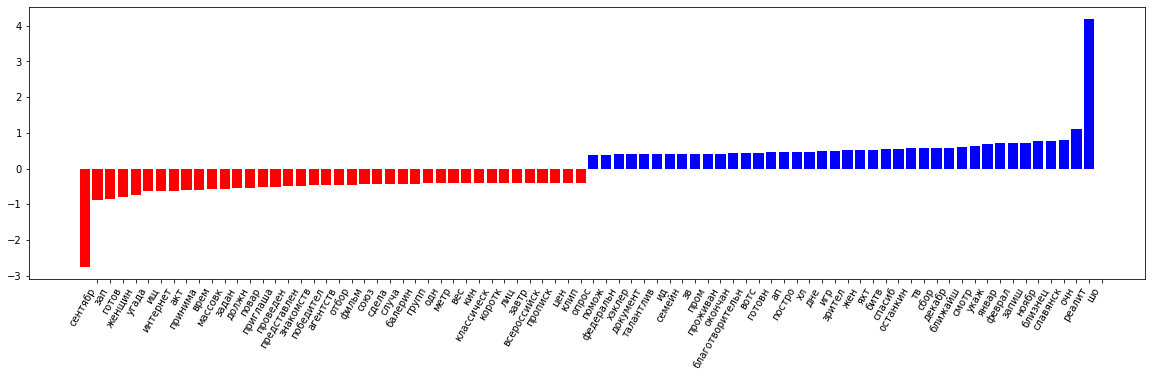

In [42]:
n_top_features = 40
# get coefficients with large absolute values 
coef = logit.coef_.ravel()
positive_coefficients = np.argsort(coef)[-n_top_features:]
negative_coefficients = np.argsort(coef)[:n_top_features]
interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])

# plot them
plt.figure(figsize=(20, 5))
colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
feature_names = np.array(feature_names)
plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");

In [181]:
# порождаем данные
rng = np.random.RandomState(0)
X = rng.randn(200, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

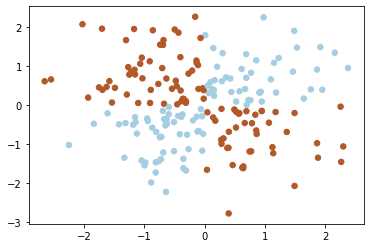

In [133]:
plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired);

In [66]:
n_top_features = 40
coef = logit.coef_.ravel() #Функция ravel() возвращает сжатый до одной оси массив.
coefficients = np.argsort(coef)
coefficients = coefficients[-n_top_features:]
coefficients = coefficients[::-1]
feature_names[interesting_coefficients]

index = 0
print("Слова и коэффициенты с большими абсолютными значениями:")
for c in coefficients:
    index = index + 1
    name = feature_names[c]
    print(str(index) + " - " + name + " (" + str(c) + ")")



Слова и коэффициенты с большими абсолютными значениями:
1 - шо (11852)
2 - реалит (8817)
3 - очн (6679)
4 - славянск (9573)
5 - близнец (694)
6 - ноябр (5971)
7 - запиш (3059)
8 - феврал (11191)
9 - январ (12140)
10 - укаж (10915)
11 - смотр (9661)
12 - ближайш (687)
13 - декабр (2243)
14 - сбор (9239)
15 - тв (10409)
16 - останкин (6461)
17 - спасиб (9900)
18 - битв (660)
19 - яхт (12166)
20 - жен (2769)
21 - зрител (3282)
22 - игр (3308)
23 - дне (2434)
24 - хл (11455)
25 - постро (7703)
26 - ап (287)
27 - готовн (2028)
28 - вотс (1499)
29 - благотворительн (672)
30 - окончан (6273)
31 - проживан (8269)
32 - пром (8321)
33 - зв (3172)
34 - семейн (9363)
35 - ид (3318)
36 - талантлив (10362)
37 - документ (2501)
38 - хэклер (11545)
39 - федеральн (11194)
40 - помож (7541)


### Првоерка модели на данных 

In [111]:
texts = ["asfsadasdfsd sd gsdg sdg sdgsdg sdg", "тв шоу для актеров"]
result = logit.predict_proba(result_x)
print("Вероятность - текст")
for i in range(0, len(texts)):
    print(str(result[i][1]) + " : " + texts[i])

Вероятность - текст
0.01743941327122247 : asfsadasdfsd sd gsdg sdg sdgsdg sdg
0.030472457100055597 : тв шоу для актеров
